In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read in all the words
words = open('../names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [5]:
# build the vocabulary of characters and mappings to/from inegers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [10]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words[:5]:

    print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] # crop off first element, add next character

X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [11]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [12]:
X

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1],
        [ 0,  0,  0],
        [ 0,  0, 15],
        [ 0, 15, 12],
        [15, 12,  9],
        [12,  9, 22],
        [ 9, 22,  9],
        [22,  9,  1],
        [ 0,  0,  0],
        [ 0,  0,  1],
        [ 0,  1, 22],
        [ 1, 22,  1],
        [ 0,  0,  0],
        [ 0,  0,  9],
        [ 0,  9, 19],
        [ 9, 19,  1],
        [19,  1,  2],
        [ 1,  2,  5],
        [ 2,  5, 12],
        [ 5, 12, 12],
        [12, 12,  1],
        [ 0,  0,  0],
        [ 0,  0, 19],
        [ 0, 19, 15],
        [19, 15, 16],
        [15, 16,  8],
        [16,  8,  9],
        [ 8,  9,  1]])

### Embed the characters into a vector space

In [13]:
C = torch.randn(27, 2) # each of the 27 characters gets represented in 2 dimensions
# note that this is equivalent to torch.nn.Embedding(27, 2)

In [15]:
C[5]

tensor([0.3433, 1.0733])

In [19]:
# C[5] is equivalent to:
F.one_hot(torch.tensor(5), 27).float() @ C
# but we will use C[ix] because it is more efficient

tensor([0.3433, 1.0733])

In [22]:
# indexing C with a list of indices returns a tensor of the same shape as the list
C[torch.tensor([5, 6, 7, 7, 7])]

tensor([[ 0.3433,  1.0733],
        [ 0.9626,  1.5923],
        [ 0.2637, -0.3594],
        [ 0.2637, -0.3594],
        [ 0.2637, -0.3594]])

In [24]:
C[X].shape
# 32 is the batch size, 3 is the context length, 2 is the embedding size

torch.Size([32, 3, 2])

In [25]:
X[13, 2] # the second 'a' in 'ava'

tensor(1)

In [26]:
C[X[13, 2]] # the embedding for 'a'

tensor([-0.5581, -0.7261])

In [27]:
emb = C[X]
emb.shape
# 32 is the batch size, 3 is the context length, 2 is the embedding size

torch.Size([32, 3, 2])

In [28]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [30]:
# emb (32, 3, 2) needs to be reshaped to (32, 6)
emb[:, 0, :].shape # (32, 2): embedding of first character in each word
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], dim=1).shape

torch.Size([32, 6])

In [34]:
# or, more generally:
torch.cat(torch.unbind(emb, dim=1), dim=1).shape
# though this is inefficient because it creates entirely new tensors

torch.Size([32, 6])

In [35]:
# side note: torch view

a = torch.arange(18)
a

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [37]:
a.view(3, 3, 2)
# this is extremely efficient, because no memory is copied, just a different view of the same data
# a.storage() is the same before and after

tensor([[[ 0,  1],
         [ 2,  3],
         [ 4,  5]],

        [[ 6,  7],
         [ 8,  9],
         [10, 11]],

        [[12, 13],
         [14, 15],
         [16, 17]]])

In [38]:
# back to emb
emb.shape

torch.Size([32, 3, 2])

In [41]:
emb.view(32, 6).shape # more efficient than torch.cat(torch.unbind(emb, dim=1), dim=1)

torch.Size([32, 6])

In [44]:
# hidden layer
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
# note: using -1 in a shape means "infer this dimension from the other dimensions"

In [45]:
h.shape

torch.Size([32, 100])

In [46]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [47]:
logits = h @ W2 + b2

In [48]:
logits.shape

torch.Size([32, 27])

In [50]:
counts = logits.exp()

In [51]:
prob = counts / counts.sum(dim=1, keepdim=True)

In [52]:
prob.shape

torch.Size([32, 27])

In [54]:
torch.arange(32) # iterator over 0 to 31

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [59]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

In [58]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(16.6479)

### Make code respectable

In [61]:
X.shape, Y.shape

(torch.Size([32, 3]), torch.Size([32]))

In [62]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [64]:
sum(p.nelement() for p in parameters) # total number of parameters

3481

In [68]:
for p in parameters:
    p.requires_grad = True

In [71]:
for _ in range(1000):

    # forward pass
    emb = C[X] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    # counts = logits.exp()
    # prob = counts / counts.sum(dim=1, keepdim=True)
    # loss = -prob[torch.arange(32), Y].log().mean()
    loss = F.cross_entropy(logits, Y) # equivalent to the above 3 lines
    # note: reasons to use F.cross_entropy instead of homemade:
    # 1. much more efficient forward and backward pass (as backward can be calculated in one step)
    # 2. numerical stability (logits are clamped to avoid overflow)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    for p in parameters:
        p.data -= 0.1 * p.grad

print(loss.item())

0.2556048631668091


### Use full dataset (instead of just first 5 words)

In [72]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:

    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix] # crop off first element, add next character

X = torch.tensor(X)
Y = torch.tensor(Y)

In [73]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [113]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

sum(p.nelement() for p in parameters) # total number of parameters

3481

In [103]:
# learning rate exponents
lre = torch.linspace(-3, 0, 1000)
lrs = 10 ** lre

In [121]:
lri = []
lossi = []

for i in range(10_000):

    # minibatch construct
    ix = torch.randint(0, X.shape[0], (32,)) # 32 random integers between 0 and X.shape[0]
    # note: minibatches are used as it is much better to calculate an approximate gradient, 
    # and take more steps, rather than calculate an exact gradient and take fewer steps
    
    # forward pass
    emb = C[X[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y[ix])

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    # lr = lrs[i]
    lr = 0.001
    for p in parameters:
        p.data -= lr * p.grad

    # track stats
#    lri.append(lre[i])
#    lossi.append(loss.item())

print(loss.item()) # this is just the loss for the minibatch, not the whole dataset

2.167186975479126


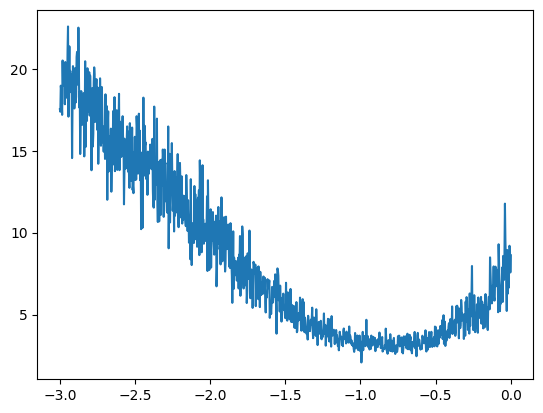

In [109]:
plt.plot(lri, lossi)
# Determine good learning rate by looking at the graph
# in this case, a good learning rate could be 10^(-1) aka 0.1, as the loss is low and stable

In [101]:
# full dataset
emb = C[X] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Y)
loss

tensor(2.5451, grad_fn=<NllLossBackward0>)